In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [34]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210512'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01,  8.77it/s]


(632049, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(629516, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '관악구'
target_dong = '신림동'
target_purpose = '3종일반'
target_building_age = 5
target_period = 18 # in months

In [37]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(412, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
70335,서울특별시 관악구 신림동 306-18,호암로16길 61,신림리하우스,29.87,23.96,23000,2,2018.0,2.0,2020-05-16,770.003348,3.0,대,182.0,제1종일반주거지역,지정되지않음,다세대,급경사,정방형,세로각지(가),관악구,신림동
70336,서울특별시 관악구 신림동 306-18,호암로16길 61,신림리하우스,29.51,23.66,20000,1,2018.0,2.0,2020-11-10,677.736361,3.0,대,182.0,제1종일반주거지역,지정되지않음,다세대,급경사,정방형,세로각지(가),관악구,신림동
70572,서울특별시 관악구 신림동 596-7,난우12길 16-12,(596-7),24.04,18.80,23000,4,2020.0,0.0,2020-05-11,956.738769,1.0,대,238.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,세로한면(불),관악구,신림동
70717,서울특별시 관악구 신림동 685-70,난곡로11길 26-6,난향하우스(685-70),29.28,24.96,22500,4,2017.0,3.0,2020-06-24,768.442623,4.0,대,205.0,제1종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(불),관악구,신림동
71006,서울특별시 관악구 신림동 650-57,난곡로26나길 30,CG아름채,29.35,16.37,27500,2,2019.0,0.0,2019-11-29,936.967632,2.0,대,299.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,세로각지(가),관악구,신림동


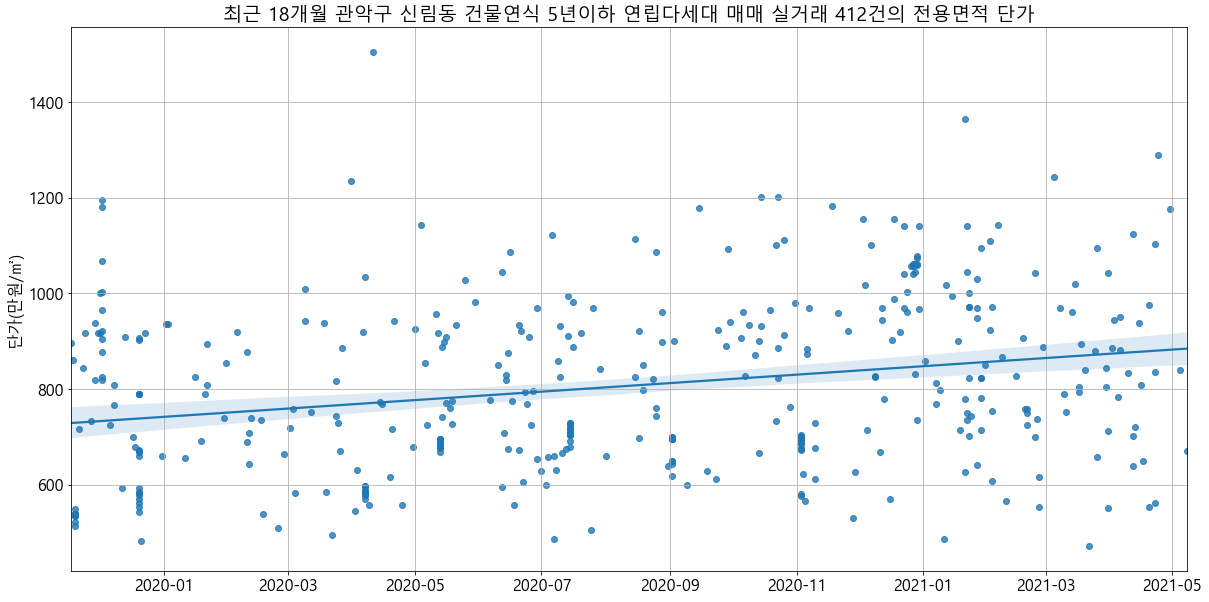

In [38]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [91]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(4694, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
69990,서울특별시 관악구 신림동 10-447,남부순환로194길 38,(10-447),56.12,27.69,13000,1,2003.0,3.0,2006-12-23,231.646472,18.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동
69991,서울특별시 관악구 신림동 10-447,남부순환로194길 38,(10-447),52.52,25.92,13500,2,2003.0,3.0,2006-12-30,257.044935,18.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동
69992,서울특별시 관악구 신림동 10-447,남부순환로194길 38,(10-447),52.52,25.92,19700,3,2003.0,5.0,2008-03-20,375.095202,18.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동
70011,서울특별시 관악구 신림동 10-584,남부순환로194길 10,(10-584),65.15,33.48,28000,4,2006.0,0.0,2006-09-01,429.777437,15.0,대,225.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동
70012,서울특별시 관악구 신림동 10-584,남부순환로194길 10,(10-584),91.05,46.79,40000,3,2006.0,0.0,2006-09-01,439.319055,15.0,대,225.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동


In [92]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]
filenames

['지역별_연립다세대_실거래가격지수_200601_202102.xlsx']

In [93]:
sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 365)


지 역 2006년 01월     2006년 02월       2006년 03월       2006년 04월  \
  Unnamed: 0_level_1        지수 변동률        지수   변동률        지수   변동률        지수   
0                 서울    50.174   -    49.868 -0.61    51.623  3.52    53.023   

        2006년 05월       2006년 06월       2006년 07월       2006년 08월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.71    53.471  0.84    53.541  0.13    55.004  2.73    57.288  4.15   

  2006년 09월       2006년 10월       2006년 11월       2006년 12월      2007년 01월  \
         지수   변동률        지수   변동률        지수   변동률        지수  변동률        지수   
0    59.279  3.48    62.222  4.96    64.449  3.58    65.672  1.9    67.433   

        2007년 02월       2007년 03월       2007년 04월       2007년 05월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.68    67.316 -0.17    68.825  2.24    70.773  2.83    71.227  0.64   

  2007년 06월       2007년 07월       2007년 08월       2007년 09월       2007년 10월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    73.664  3.42    75.501  2.49    76.363  1.14    77.716  1.77    80.412   

        2007년 11월       2007년 12월       2008년 01월       2008년 02월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  3.47    81.322  1.13    82.895  1.93    85.315  2.92    86.909  1.87   

  2008년 03월       2008년 04월       2008년 05월       2008년 06월      2008년 07월  \
         지수   변동률        지수   변동률        지수   변동률        지수  변동률        지수   
0    91.072  4.79    94.429  3.69    97.021  2.74    97.898  0.9    96.642   

        2008년 08월       2008년 09월       2008년 10월       2008년 11월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -1.28    95.315 -1.37    94.819 -0.52    91.804 -3.18    87.269 -4.94   

  2008년 12월       2009년 01월       2009년 02월       2009년 03월       2009년 04월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    84.235 -3.48    84.433  0.23    85.689  1.49    86.418  0.85    88.165   

        2009년 05월       2009년 06월       2009년 07월       2009년 08월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.02    90.322  2.45    90.921  0.66    92.781  2.05    94.755  2.13   

  2009년 09월       2009년 10월       2009년 11월       2009년 12월       2010년 01월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    96.235  1.56    95.553 -0.71    94.461 -1.14    94.582  0.13    96.148   

        2010년 02월       2010년 03월       2010년 04월       2010년 05월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  1.66     95.87 -0.29    95.305 -0.59    94.813 -0.52    94.425 -0.41   

  2010년 06월       2010년 07월       2010년 08월       2010년 09월       2010년 10월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    92.574 -1.96    91.908 -0.72    91.419 -0.53    91.379 -0.04    90.753   

        2010년 11월       2010년 12월       2011년 01월       2011년 02월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -0.69    91.374  0.68    91.589  0.24     91.95  0.39    92.705  0.82   

  2011년 03월       2011년 04월       2011년 05월       2011년 06월       2011년 07월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    92.885  0.19     92.35 -0.58    92.618  0.29    91.888 -0.79    91.628   

        2011년 08월       2011년 09월       2011년 10월       2011년 11월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -0.28    91.073 -0.61    91.898  0.91    91.392 -0.55    90.653 -0.81   

  2011년 12월       2012년 01월       2012년 02월       2012년 03월       2012년 04월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    89.877 -0.86    90.529  0.73    90.105 -0.47    89.855 -0.28    88.579   

        2012년 05월       2012년 06월       2012년 07월       2012년 08월     

In [94]:
sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

In [95]:
sales_idx_df.columns = sales_idx_cols_list
sales_idx_df.head()

,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [96]:
last_idx = sales_idx_df.iloc[0,-2]
last_idx

124.636

In [97]:
last_date = sales_idx_df.columns[-1].split('_')[0]
last_date

'2021년 02월'

In [98]:
last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
last_date

'2021-02-01'

In [99]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [100]:
target_upper_limit_df = target_df2[target_df2['계약날짜'] <= pd.to_datetime(last_date)]

In [101]:
target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)

In [102]:
target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx

In [103]:
target_upper_limit_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,계약날짜_실거래지수,지수적용단가
69990,서울특별시 관악구 신림동 10-447,남부순환로194길 38,(10-447),56.12,27.69,13000,1,2003.0,3.0,2006-12-23,231.646472,18.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동,65.672,439.631649
69991,서울특별시 관악구 신림동 10-447,남부순환로194길 38,(10-447),52.52,25.92,13500,2,2003.0,3.0,2006-12-30,257.044935,18.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동,65.672,487.834276
69992,서울특별시 관악구 신림동 10-447,남부순환로194길 38,(10-447),52.52,25.92,19700,3,2003.0,5.0,2008-03-20,375.095202,18.0,대,192.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동,91.072,513.334127
70011,서울특별시 관악구 신림동 10-584,남부순환로194길 10,(10-584),65.15,33.48,28000,4,2006.0,0.0,2006-09-01,429.777437,15.0,대,225.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동,59.279,903.620854
70012,서울특별시 관악구 신림동 10-584,남부순환로194길 10,(10-584),91.05,46.79,40000,3,2006.0,0.0,2006-09-01,439.319055,15.0,대,225.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로각지(가),관악구,신림동,59.279,923.682414


In [104]:
target_df2['지수적용단가'] = target_df2['단가(만원/㎡)']

In [105]:
target_df2.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']

In [106]:
target_df2['평가날짜'] = target_df2['계약날짜']

In [107]:
target_df2.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '15')

<AxesSubplot:title={'center':'관악구 신림동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 4694건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

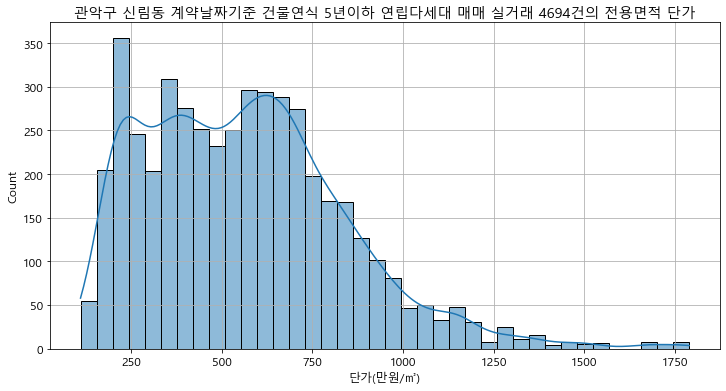

In [108]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [159]:
concat_df = pd.concat([target_df2])

In [160]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [161]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [162]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(2330, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 관악구 신림동 10-172,남부순환로190길 49,장군산장빌라,67.00,30.69,15500,1,2001.0,5.0,2006-12-11,231.343284,20.0,대,245.0,제1종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),관악구,신림동,439.056242,2021-02-15,231.343284,439.056242
1,서울특별시 관악구 신림동 10-199,남부순환로190길 10-6,모산아트빌라,53.32,24.36,15600,2,2003.0,4.0,2007-08-08,292.573143,18.0,대,112.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(불),관악구,신림동,477.523752,2021-02-15,239.628202,392.848940
2,서울특별시 관악구 신림동 10-199,남부순환로190길 10-6,모산아트빌라,96.42,44.05,18000,3,2003.0,4.0,2007-07-20,186.683261,18.0,대,112.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(불),관악구,신림동,308.174129,2021-02-15,239.628202,392.848940
3,서울특별시 관악구 신림동 10-232,남부순환로186가길 21,운서맨션10차,39.34,20.85,9500,4,2002.0,4.0,2006-11-21,241.484494,19.0,대,162.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),관악구,신림동,466.999665,2021-02-15,252.898770,459.529404
4,서울특별시 관악구 신림동 10-232,남부순환로186가길 21,운서맨션10차,41.63,22.07,10500,2,2002.0,5.0,2007-12-22,252.221955,19.0,대,162.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),관악구,신림동,379.225956,2021-02-15,252.898770,459.529404


In [163]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(882, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 관악구 신림동 10-172,남부순환로190길 49,장군산장빌라,67.00,30.69,15500,1,2001.0,5.0,2006-12-11,231.343284,20.0,대,245.0,제1종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),관악구,신림동,439.056242,2021-02-15,231.343284,439.056242
2,서울특별시 관악구 신림동 10-199,남부순환로190길 10-6,모산아트빌라,96.42,44.05,18000,3,2003.0,4.0,2007-07-20,186.683261,18.0,대,112.0,제2종일반주거지역,지정되지않음,다세대,완경사,세로장방,세로한면(불),관악구,신림동,308.174129,2021-02-15,239.628202,392.848940
6,서울특별시 관악구 신림동 10-232,남부순환로186가길 21,운서맨션10차,51.94,27.54,13000,2,2002.0,4.0,2006-11-03,250.288795,19.0,대,162.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),관악구,신림동,484.026040,2021-02-15,252.898770,459.529404
7,서울특별시 관악구 신림동 10-242,남부순환로186가길 24,운서맨션(나),62.24,32.27,15300,3,2001.0,5.0,2006-12-18,245.822622,20.0,대,298.0,제2종일반주거지역,지정되지않음,다세대,완경사,정방형,세로한면(가),관악구,신림동,466.535941,2021-02-15,245.822622,466.535941
11,서울특별시 관악구 신림동 10-255,남부순환로184가길 23,동문슈퍼빌(10-255),105.61,59.11,25450,4,2002.0,4.0,2006-04-15,240.980968,19.0,대,800.0,제2종일반주거지역,지정되지않음,연립,완경사,가로장방,세로각지(가),관악구,신림동,566.450482,2021-02-15,270.845462,514.074332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,서울특별시 관악구 신림동 98-54,복은10길 31-6,더퍼스트빌(98-54),29.80,23.56,18300,1,2016.0,1.0,2017-03-07,614.093960,5.0,대,139.0,제1종일반주거지역,지정되지않음,다세대,급경사,가로장방,세로한면(가),관악구,신림동,792.756013,2021-02-15,593.263408,746.142832
2320,서울특별시 관악구 신림동 98-66,복은10길 31-9,세영빌라B동,62.42,39.06,10000,2,2005.0,5.0,2010-02-10,160.205062,16.0,대,128.0,제1종일반주거지역,지정되지않음,다세대,급경사,가로장방,세로각지(가),관악구,신림동,208.274937,2021-02-15,177.127111,230.274482
2325,서울특별시 관악구 신림동 98-72,복은8길 25,힐하우스,50.48,34.10,23000,1,2010.0,3.0,2013-05-24,455.625990,11.0,대,238.0,제1종일반주거지역,지정되지않음,다세대,급경사,정방형,세로각지(가),관악구,신림동,671.420475,2021-02-15,498.075183,691.014465
2326,서울특별시 관악구 신림동 98-81,복은길 126,(98-81),71.70,27.30,9800,2,2002.0,4.0,2006-10-16,136.680614,19.0,대,268.0,제1종일반주거지역,지정되지않음,다세대,급경사,부정형,소로각지,관악구,신림동,273.782986,2021-02-15,136.680614,273.782986


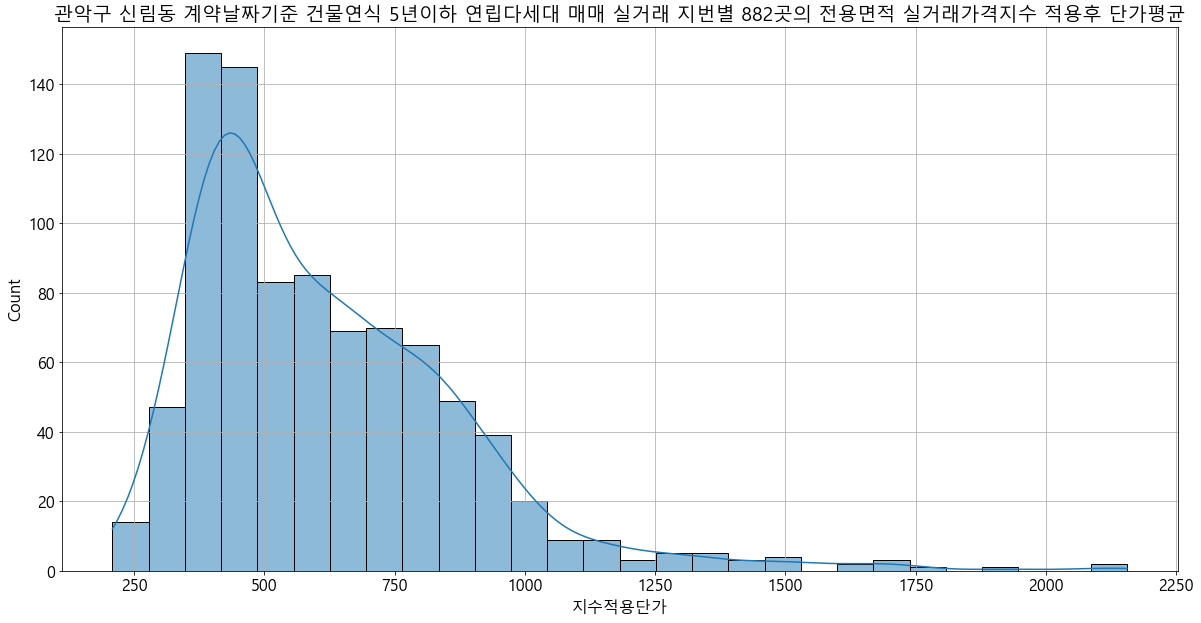

In [164]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [165]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [166]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가평균', '평가날짜', '지수적용단가평균', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가평균,평가날짜,지수적용단가평균,용도지역명1
0,서울특별시 관악구 신림동 10-172,장군산장빌라,2001.0,2006-12-11,231.343284,2021-02-15,439.056242,제1종일반주거지역
1,서울특별시 관악구 신림동 10-199,모산아트빌라,2003.0,2007-07-20,239.628202,2021-02-15,392.848940,제2종일반주거지역
2,서울특별시 관악구 신림동 10-232,운서맨션10차,2002.0,2006-11-03,252.898770,2021-02-15,459.529404,제2종일반주거지역
3,서울특별시 관악구 신림동 10-242,운서맨션(나),2001.0,2006-12-18,245.822622,2021-02-15,466.535941,제2종일반주거지역
4,서울특별시 관악구 신림동 10-255,동문슈퍼빌(10-255),2002.0,2006-04-15,270.845462,2021-02-15,514.074332,제2종일반주거지역
...,...,...,...,...,...,...,...,...
877,서울특별시 관악구 신림동 98-54,더퍼스트빌(98-54),2016.0,2017-03-07,593.263408,2021-02-15,746.142832,제1종일반주거지역
878,서울특별시 관악구 신림동 98-66,세영빌라B동,2005.0,2010-02-10,177.127111,2021-02-15,230.274482,제1종일반주거지역
879,서울특별시 관악구 신림동 98-72,힐하우스,2010.0,2013-05-24,498.075183,2021-02-15,691.014465,제1종일반주거지역
880,서울특별시 관악구 신림동 98-81,(98-81),2002.0,2006-10-16,136.680614,2021-02-15,273.782986,제1종일반주거지역


In [167]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [134]:
inv_df = house_df[house_df['지번주소'].str.contains('서울특별시 관악구 신림동 1457-7')]
print(inv_df.shape)

(16, 14)


In [135]:
inv_df

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,구,동
335338,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,14.14,9.63,25000,5,2015.0,0.0,2015-06-29,1768.033946,6.0,관악구,신림동
335339,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,23.35,15.92,25000,5,2015.0,0.0,2015-06-29,1070.663812,6.0,관악구,신림동
335340,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,14.14,9.63,25000,6,2015.0,0.0,2015-06-29,1768.033946,6.0,관악구,신림동
335341,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,23.35,15.92,25000,6,2015.0,0.0,2015-06-29,1070.663812,6.0,관악구,신림동
335342,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,23.35,15.92,25000,4,2015.0,0.0,2015-06-29,1070.663812,6.0,관악구,신림동
335343,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,14.14,9.63,25000,4,2015.0,0.0,2015-06-29,1768.033946,6.0,관악구,신림동
335344,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,14.14,9.63,25000,7,2015.0,0.0,2015-06-29,1768.033946,6.0,관악구,신림동
335345,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,23.35,15.92,25000,7,2015.0,0.0,2015-06-29,1070.663812,6.0,관악구,신림동
437748,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,14.14,9.63,17842,5,2015.0,2.0,2017-01-07,1261.810467,6.0,관악구,신림동
437749,서울특별시 관악구 신림동 1457-7,봉천로4길 64-6,샤인빌리지,14.14,9.63,17843,7,2015.0,2.0,2017-01-07,1261.881188,6.0,관악구,신림동
